<a href="https://colab.research.google.com/github/yanivniv/airbnb_income_prediction/blob/master/H.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
'''Main'''
from datetime import datetime
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
import io
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('float_format', '{:.2f}'.format)
import os
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())
import re
import holidays

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

#Data Prep
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import pearsonr 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss 
from sklearn.metrics import precision_recall_curve, average_precision_score 
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.metrics import accuracy_score
#ML
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
import pickle

import warnings
warnings.filterwarnings('ignore')


In [0]:
def add_datepart_columns(dataframe: pd.DataFrame(), dateField):
    fld = dataframe[dateField]
    if not np.issubdtype(fld.dtype, np.datetime64):
        dataframe[dateField] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', dateField)
    for n in ('Year', 'Month', 'Week', 'Day','Hour','Minute','Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start'):
        dataframe[targ_pre+n] = getattr(fld.dt,n.lower())    
    dataframe.drop(dateField, axis=1, inplace=True)   
    
def df_dummies(df, to_encode):
    temp_df = pd.get_dummies(df[[to_encode]])
    result_df = pd.concat([df, temp_df], axis=1)
    result_df = result_df.drop([to_encode], axis=1)
    #return(result_df)     

def get_min_price(df: pd.DataFrame):
    prices_sorted = df[['received_ms','total_usd']].sort_values(by='total_usd').drop_duplicates().reset_index()
    min_ts = prices_sorted.iloc[0][1]
    min_price = prices_sorted.iloc[0][2]   
    return [min_ts,min_price]

def y_label(df: pd.DataFrame):
    '''getting the search prices sorted as a reference'''
    prices_sorted = df[['received_ms','total_usd']].sort_values(by='total_usd').drop_duplicates().reset_index()
    min_ts = get_min_price(prices_sorted)[0]
    min_price =  get_min_price(prices_sorted)[1]
    '''sorting our search key by time'''
    df = df.sort_values(by='received_ms')
    for index, rec in df.iterrows():
        #checking if the price right now is the cheapest or should i wait ?
        if rec['total_usd'] == min_price and  rec['received_ms'] == min_ts:
            #bingo, this is the cheapest ! assinging '1'
            df.loc[(df['received_ms'] == min_ts) & (df['total_usd'] == min_price), 'y'] = 1
            #deleting the lowest price from the prices_sorted            
            prices_sorted = prices_sorted[prices_sorted.received_ms != min_ts]
            if not prices_sorted.empty:                
                min_ts = get_min_price(prices_sorted)[0]
                min_price =  get_min_price(prices_sorted)[1]
        else:
            #in case it's not the cheapest, remove all records from cheapest dataframe that happened before me
            prices_sorted = prices_sorted[prices_sorted.received_ms > rec['received_ms']]
    df.fillna(0)
    #print('finished ',df['PK'].unique())
    return df

def will_be_tickets_left(advance_new,available_seats) -> bool:
    if advance_new>50: #no risk that the flight will totally booked, so tickets will be left
        return True
    else:  #if less then 50 tickets left, we guestimate that 0.2 tickets will be sold daily. 
        if available_seats >= 0.2*advance_new: #checking if the amount of tickets left will be positive
            return True
    return False

In [0]:

df = pd.read_csv(io.StringIO(uploaded['boscun-longitudinal.csv'].decode('utf-8')), nrows=1000)
df


,search_id,trip_index,received_date,received_ms,origin,destination,total_usd,pax_type,refundable,validating_carrier,departure_odate,departure_ms,outgoing_duration,outgoing_stops,return_odate,return_ms,returning_duration,returning_stops,major_carrier_id,total_stops,advance,length_of_stay,includes_saturday_night_stay,available_seats,lowest_cabin_class,highest_cabin_class
0,f079363a-b281-3476-b13e-d96ba6a8ad8a,11,2016-04-21,1461268013357,BOS,CUN,397.00,ADT,nan,AM,2016-06-02,1464865260000,649,1,2016-06-06,1465221300000,615,1,AM,2,42,4,True,8,E,E
1,f079363a-b281-3476-b13e-d96ba6a8ad8a,15,2016-04-21,1461268013357,BOS,CUN,412.80,ADT,nan,UA,2016-06-02,1464865800000,467,1,2016-06-06,1465239000000,492,1,UA,2,42,4,True,8,E,E
2,f079363a-b281-3476-b13e-d96ba6a8ad8a,17,2016-04-21,1461268013357,BOS,CUN,412.80,ADT,nan,UA,2016-06-02,1464865800000,467,1,2016-06-06,1465232700000,526,1,UA,2,42,4,True,8,E,E
3,f079363a-b281-3476-b13e-d96ba6a8ad8a,19,2016-04-21,1461268013357,BOS,CUN,412.80,ADT,nan,UA,2016-06-02,1464860880000,549,1,2016-06-06,1465232700000,405,1,UA,2,42,4,True,8,E,E
4,f079363a-b281-3476-b13e-d96ba6a8ad8a,29,2016-04-21,1461268013357,BOS,CUN,412.80,ADT,nan,UA,2016-06-02,1464861300000,405,1,2016-06-06,1465232700000,526,1,UA,2,42,4,True,9,E,E
5,f079363a-b281-3476-b13e-d96ba6a8ad8a,31,2016-04-21,1461268013357,BOS,CUN,412.80,ADT,nan,UA,2016-06-02,1464861300000,405,1,2016-06-06,1465238100000,436,1,UA,2,42,4,True,9,E,E
6,f079363a-b281-3476-b13e-d96ba6a8ad8a,35,2016-04-21,1461268013357,BOS,CUN,417.30,ADT,nan,UA,2016-06-02,1464861300000,542,2,2016-06-06,1465238100000,436,1,UA,3,42,4,True,8,E,E
7,f079363a-b281-3476-b13e-d96ba6a8ad8a,55,2016-04-21,1461268013357,BOS,CUN,484.80,ADT,nan,UA,2016-06-02,1464860880000,477,1,2016-06-06,1465238100000,436,1,UA,2,42,4,True,9,E,E
8,f079363a-b281-3476-b13e-d96ba6a8ad8a,67,2016-04-21,1461268013357,BOS,CUN,484.80,ADT,nan,UA,2016-06-02,1464865740000,444,1,2016-06-06,1465239000000,492,1,UA,2,42,4,True,9,E,E
9,f079363a-b281-3476-b13e-d96ba6a8ad8a,76,2016-04-21,1461268013357,BOS,CUN,484.80,ADT,nan,UA,2016-06-02,1464865740000,386,1,2016-06-06,1465232700000,405,1,UA,2,42,4,True,9,E,E


In [0]:
#df = pd.read_csv(r"C:\Users\yaniv\Downloads\HopperQuantExercise\boscun-longitudinal.csv")
#df = pd.read_csv(r"C:\Users\yaniv\Downloads\HopperQuantExercise\boscun-longitudinal.csv")

In [0]:
#from google.colab import files
#uploaded = files.upload()

Exploring the data

In [0]:
display(df.head(5))
display(df.shape)

,search_id,trip_index,received_date,received_ms,origin,destination,total_usd,pax_type,refundable,validating_carrier,departure_odate,departure_ms,outgoing_duration,outgoing_stops,return_odate,return_ms,returning_duration,returning_stops,major_carrier_id,total_stops,advance,length_of_stay,includes_saturday_night_stay,available_seats,lowest_cabin_class,highest_cabin_class
0,f079363a-b281-3476-b13e-d96ba6a8ad8a,11,2016-04-21,1461268013357,BOS,CUN,397.00,ADT,nan,AM,2016-06-02,1464865260000,649,1,2016-06-06,1465221300000,615,1,AM,2,42,4,True,8,E,E
1,f079363a-b281-3476-b13e-d96ba6a8ad8a,15,2016-04-21,1461268013357,BOS,CUN,412.80,ADT,nan,UA,2016-06-02,1464865800000,467,1,2016-06-06,1465239000000,492,1,UA,2,42,4,True,8,E,E
2,f079363a-b281-3476-b13e-d96ba6a8ad8a,17,2016-04-21,1461268013357,BOS,CUN,412.80,ADT,nan,UA,2016-06-02,1464865800000,467,1,2016-06-06,1465232700000,526,1,UA,2,42,4,True,8,E,E
3,f079363a-b281-3476-b13e-d96ba6a8ad8a,19,2016-04-21,1461268013357,BOS,CUN,412.80,ADT,nan,UA,2016-06-02,1464860880000,549,1,2016-06-06,1465232700000,405,1,UA,2,42,4,True,8,E,E
4,f079363a-b281-3476-b13e-d96ba6a8ad8a,29,2016-04-21,1461268013357,BOS,CUN,412.80,ADT,nan,UA,2016-06-02,1464861300000,405,1,2016-06-06,1465232700000,526,1,UA,2,42,4,True,9,E,E


(100000, 26)

In [0]:
#explorying a random search
df.query('search_id == "f079363a-b281-3476-b13e-d96ba6a8ad8a"').sort_values(by='trip_index')
#flight search seems to be the following: bos->cun, depart:2016-06-02, return:2016-06-06, lowest_class='E', highest_class='F'/
#Intersting facts: total_stops is not part of the search, as we got back multiple values.

,search_id,trip_index,received_date,received_ms,origin,destination,total_usd,pax_type,refundable,validating_carrier,departure_odate,departure_ms,outgoing_duration,outgoing_stops,return_odate,return_ms,returning_duration,returning_stops,major_carrier_id,total_stops,advance,length_of_stay,includes_saturday_night_stay,available_seats,lowest_cabin_class,highest_cabin_class
0,f079363a-b281-3476-b13e-d96ba6a8ad8a,11,2016-04-21,1461268013357,BOS,CUN,397.00,ADT,nan,AM,2016-06-02,1464865260000,649,1,2016-06-06,1465221300000,615,1,AM,2,42,4,True,8,E,E
1,f079363a-b281-3476-b13e-d96ba6a8ad8a,15,2016-04-21,1461268013357,BOS,CUN,412.80,ADT,nan,UA,2016-06-02,1464865800000,467,1,2016-06-06,1465239000000,492,1,UA,2,42,4,True,8,E,E
2,f079363a-b281-3476-b13e-d96ba6a8ad8a,17,2016-04-21,1461268013357,BOS,CUN,412.80,ADT,nan,UA,2016-06-02,1464865800000,467,1,2016-06-06,1465232700000,526,1,UA,2,42,4,True,8,E,E
3,f079363a-b281-3476-b13e-d96ba6a8ad8a,19,2016-04-21,1461268013357,BOS,CUN,412.80,ADT,nan,UA,2016-06-02,1464860880000,549,1,2016-06-06,1465232700000,405,1,UA,2,42,4,True,8,E,E
4,f079363a-b281-3476-b13e-d96ba6a8ad8a,29,2016-04-21,1461268013357,BOS,CUN,412.80,ADT,nan,UA,2016-06-02,1464861300000,405,1,2016-06-06,1465232700000,526,1,UA,2,42,4,True,9,E,E
5,f079363a-b281-3476-b13e-d96ba6a8ad8a,31,2016-04-21,1461268013357,BOS,CUN,412.80,ADT,nan,UA,2016-06-02,1464861300000,405,1,2016-06-06,1465238100000,436,1,UA,2,42,4,True,9,E,E
6,f079363a-b281-3476-b13e-d96ba6a8ad8a,35,2016-04-21,1461268013357,BOS,CUN,417.30,ADT,nan,UA,2016-06-02,1464861300000,542,2,2016-06-06,1465238100000,436,1,UA,3,42,4,True,8,E,E
7,f079363a-b281-3476-b13e-d96ba6a8ad8a,55,2016-04-21,1461268013357,BOS,CUN,484.80,ADT,nan,UA,2016-06-02,1464860880000,477,1,2016-06-06,1465238100000,436,1,UA,2,42,4,True,9,E,E
8,f079363a-b281-3476-b13e-d96ba6a8ad8a,67,2016-04-21,1461268013357,BOS,CUN,484.80,ADT,nan,UA,2016-06-02,1464865740000,444,1,2016-06-06,1465239000000,492,1,UA,2,42,4,True,9,E,E
9,f079363a-b281-3476-b13e-d96ba6a8ad8a,76,2016-04-21,1461268013357,BOS,CUN,484.80,ADT,nan,UA,2016-06-02,1464865740000,386,1,2016-06-06,1465232700000,405,1,UA,2,42,4,True,9,E,E


In [0]:
df.describe()

,trip_index,received_ms,total_usd,refundable,departure_ms,outgoing_duration,outgoing_stops,return_ms,returning_duration,returning_stops,total_stops,advance,length_of_stay,available_seats
count,100000.00,100000.00,100000.00,0.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00
mean,93.85,1463000351566.62,629.03,nan,1470780236227.80,575.97,1.11,1471351985908.80,571.10,1.06,2.17,90.23,6.48,5.45
std,55.79,12360452450.57,279.21,nan,13977528490.03,239.76,0.38,13979991977.51,220.65,0.35,0.56,70.17,5.54,3.13
min,0.00,1438516585502.00,252.69,nan,1438680000000.00,256.00,0.00,1439208000000.00,237.00,0.00,0.00,0.00,0.00,1.00
25%,46.00,1452039757754.00,443.43,nan,1460140800000.00,410.00,1.00,1460806200000.00,431.00,1.00,2.00,33.00,5.00,2.00
50%,93.00,1461292359409.00,566.52,nan,1472035200000.00,495.00,1.00,1472576700000.00,507.00,1.00,2.00,75.00,6.00,5.00
75%,141.00,1472958207781.00,735.69,nan,1482588000000.00,641.00,1.00,1483212000000.00,629.00,1.00,2.00,133.00,7.00,9.00
max,210.00,1479962776381.00,4673.61,nan,1504409400000.00,1820.00,3.00,1504986300000.00,1807.00,3.00,5.00,335.00,201.00,9.00


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 26 columns):
search_id                       100000 non-null object
trip_index                      100000 non-null int64
received_date                   100000 non-null object
received_ms                     100000 non-null int64
origin                          100000 non-null object
destination                     100000 non-null object
total_usd                       100000 non-null float64
pax_type                        81307 non-null object
refundable                      0 non-null float64
validating_carrier              81307 non-null object
departure_odate                 100000 non-null object
departure_ms                    100000 non-null int64
outgoing_duration               100000 non-null int64
outgoing_stops                  100000 non-null int64
return_odate                    100000 non-null object
return_ms                       100000 non-null int64
returning_duration   

In [0]:
#Detecting null percentage
df.isna().sum()/df.count()

search_id                      0.00
trip_index                     0.00
received_date                  0.00
received_ms                    0.00
origin                         0.00
destination                    0.00
total_usd                      0.00
pax_type                       0.23
refundable                      inf
validating_carrier             0.23
departure_odate                0.00
departure_ms                   0.00
outgoing_duration              0.00
outgoing_stops                 0.00
return_odate                   0.00
return_ms                      0.00
returning_duration             0.00
returning_stops                0.00
major_carrier_id               0.00
total_stops                    0.00
advance                        0.00
length_of_stay                 0.00
includes_saturday_night_stay   0.00
available_seats                0.00
lowest_cabin_class             0.00
highest_cabin_class            0.00
dtype: float64

Only 3 columns has missing data (pax_type, refundable, validating_carrier)

In [0]:
#Exploring unique values
df.nunique().sort_values()

refundable                          0
origin                              1
destination                         1
pax_type                            1
lowest_cabin_class                  2
includes_saturday_night_stay        2
highest_cabin_class                 4
returning_stops                     4
outgoing_stops                      4
total_stops                         6
available_seats                     9
validating_carrier                 10
major_carrier_id                   11
received_date                      21
length_of_stay                     36
trip_index                        211
advance                           306
departure_odate                   541
return_odate                      558
returning_duration               1110
outgoing_duration                1178
received_ms                      4204
search_id                        4204
total_usd                       13497
return_ms                       13676
departure_ms                    15630
dtype: int64

Columns with single value are not useful in our statistical modelling. We will drop them. 
trip_index and search_id are not adding any useful information as well, as it looks random

In [0]:
df_reduced = df.drop(columns=['search_id','refundable','origin','destination','pax_type','trip_index'])

We have milliseconds, so we might as well create an accurate "advance" column

In [0]:
df_reduced['advance'] = (df_reduced['departure_ms'] - df_reduced['received_ms'])/(60*60*24*1000)

Change column types

In [0]:
df_reduced['received_date'] = pd.to_datetime(df_reduced['received_date'])
df_reduced['departure_odate'] = pd.to_datetime(df_reduced['departure_odate'])
df_reduced['return_odate'] = pd.to_datetime(df_reduced['return_odate'])

In [0]:
df_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 20 columns):
received_date                   100000 non-null datetime64[ns]
received_ms                     100000 non-null int64
total_usd                       100000 non-null float64
validating_carrier              81307 non-null object
departure_odate                 100000 non-null datetime64[ns]
departure_ms                    100000 non-null int64
outgoing_duration               100000 non-null int64
outgoing_stops                  100000 non-null int64
return_odate                    100000 non-null datetime64[ns]
return_ms                       100000 non-null int64
returning_duration              100000 non-null int64
returning_stops                 100000 non-null int64
major_carrier_id                100000 non-null object
total_stops                     100000 non-null int64
advance                         100000 non-null float64
length_of_stay                  100000 non-null 

In [0]:
df_reduced['available_seats'].unique()

array([8, 9, 4, 3, 1, 6, 7, 2, 5])

Creating a search key data frame, as a helpful table. The key is constructed with
departure, return, lowest cabin class, highest cabin class, outgoing stops, returning stops. 

In [0]:
key_df = df_reduced.drop_duplicates(['departure_odate','return_odate','lowest_cabin_class','highest_cabin_class','outgoing_stops','returning_stops'])[['departure_odate','return_odate','lowest_cabin_class','highest_cabin_class','outgoing_stops','returning_stops']]

In [0]:
key_df.head(10)

,departure_odate,return_odate,lowest_cabin_class,highest_cabin_class,outgoing_stops,returning_stops
0,2016-06-02,2016-06-06,E,E,1,1
6,2016-06-02,2016-06-06,E,E,2,1
12,2016-06-02,2016-06-06,E,E,2,2
15,2016-05-12,2016-05-16,E,E,1,1
17,2016-05-12,2016-05-16,E,E,2,1
21,2017-01-18,2017-01-25,E,E,1,1
38,2017-01-18,2017-01-25,E,E,2,1
39,2016-08-25,2016-08-30,E,E,1,1
43,2016-08-25,2016-08-30,E,E,2,1
44,2016-08-25,2016-08-30,E,E,1,2


Assigning PK for every unique search

In [0]:
key_df['PK'] = np.arange(len(key_df))
key_df.head(4)

,departure_odate,return_odate,lowest_cabin_class,highest_cabin_class,outgoing_stops,returning_stops,PK
0,2016-06-02,2016-06-06,E,E,1,1,0
6,2016-06-02,2016-06-06,E,E,2,1,1
12,2016-06-02,2016-06-06,E,E,2,2,2
15,2016-05-12,2016-05-16,E,E,1,1,3


Creating date-range holiday flag

In [0]:
date_range = key_df.drop_duplicates(['departure_odate','return_odate'])[['departure_odate','return_odate']]
date_range.shape

(1507, 2)

Marking a holiday in the range of depart/return, per each search

In [0]:
date_range['Holiday'] = date_range.apply(lambda x:calendar().holidays(start=x['departure_odate'],end=x['return_odate']).size, axis=1).astype(bool)


In [0]:
date_range.head(20)

,departure_odate,return_odate,Holiday
0,2016-06-02,2016-06-06,False
15,2016-05-12,2016-05-16,False
21,2017-01-18,2017-01-25,False
39,2016-08-25,2016-08-30,False
68,2016-05-25,2016-05-31,True
90,2016-05-27,2016-05-30,True
122,2016-05-18,2016-05-31,True
145,2016-05-30,2016-06-04,True
163,2016-05-09,2016-05-15,False
164,2016-05-11,2016-05-15,False


In [0]:
key_df = pd.merge(key_df, date_range, how='inner', on=['departure_odate', 'return_odate'])

Assiging the PK to the reduced data frame

In [0]:
df_reduced = pd.merge(df_reduced, key_df, how='inner', on=['departure_odate', 'return_odate', 'lowest_cabin_class', 'highest_cabin_class', 'outgoing_stops', 'returning_stops'])
df_reduced = df_reduced.drop_duplicates()

In [0]:
df_reduced.shape

(99780, 22)

***Handling the y class***

In [0]:
df_reduced['y'] = 0

In [0]:
for pk in df_reduced['PK'].unique():
    df_reduced.loc[:,'y'][df_reduced.PK == pk] = y_label(df_reduced[df_reduced.PK == pk])['y']

In [0]:
df_reduced.head(1)

,received_date,received_ms,total_usd,validating_carrier,departure_odate,departure_ms,outgoing_duration,outgoing_stops,return_odate,return_ms,returning_duration,returning_stops,major_carrier_id,total_stops,advance,length_of_stay,includes_saturday_night_stay,available_seats,lowest_cabin_class,highest_cabin_class,PK,Holiday,y
0,2016-04-21,1461268013357,397.00,AM,2016-06-02,1464865260000,649,1,2016-06-06,1465221300000,615,1,AM,2,41.63,4,True,8,E,E,0,False,1


In [0]:
df_reduced.shape

(99780, 23)

***Pre Processing of the data***

In [0]:
data = df_reduced[['received_ms','total_usd','y']][df_reduced['PK'] == 3]
data.sort_values(by='received_ms').head()

,received_ms,total_usd,y
215,1450108241298,538.21,0
213,1450108241298,523.21,0
212,1450108241298,518.21,0
211,1450108241298,503.21,0
210,1450108241298,503.21,0


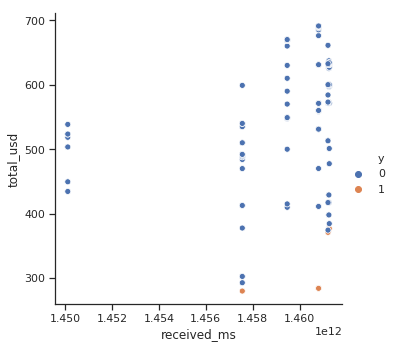

In [0]:
#sns.lineplot(x='advance',y='total_usd',data=data)
sns.set(style="ticks")
sns.relplot(x="received_ms", y="total_usd",data=data, hue='y')

#display(data)

In [0]:
#y_label(df_reduced[df_reduced.PK == 10]).sort_values(by='')

***Transformation of date columns***

*Chaniging date columns to date time, utilizing the information from the epoch columns*

In [0]:
df_reduced['received_date'] = df_reduced['received_ms'].apply(lambda x: datetime.fromtimestamp(x/1000).strftime('%Y-%m-%d %H:%M:%S'))
df_reduced['departure_odate'] = df_reduced['departure_ms'].apply(lambda x: datetime.fromtimestamp(x/1000).strftime('%Y-%m-%d %H:%M:%S'))
df_reduced['return_odate'] = df_reduced['return_ms'].apply(lambda x: datetime.fromtimestamp(x/1000).strftime('%Y-%m-%d %H:%M:%S'))

In [0]:
date_cols = ['received_date','departure_odate','return_odate']

Extracting useful information from datetime columns

In [0]:
for d in date_cols:
    add_datepart_columns(df_reduced,d)

In [0]:
display(df_reduced.head(2))
display(df_reduced.shape)

,received_ms,total_usd,validating_carrier,departure_ms,outgoing_duration,outgoing_stops,return_ms,returning_duration,returning_stops,major_carrier_id,total_stops,advance,length_of_stay,includes_saturday_night_stay,available_seats,lowest_cabin_class,highest_cabin_class,PK,Holiday,y,received_Year,received_Month,received_Week,received_Day,received_Hour,received_Minute,received_Dayofweek,received_Dayofyear,received_Is_month_end,received_Is_month_start,received_Is_quarter_end,received_Is_quarter_start,received_Is_year_end,received_Is_year_start,departure_oYear,departure_oMonth,departure_oWeek,departure_oDay,departure_oHour,departure_oMinute,departure_oDayofweek,departure_oDayofyear,departure_oIs_month_end,departure_oIs_month_start,departure_oIs_quarter_end,departure_oIs_quarter_start,departure_oIs_year_end,departure_oIs_year_start,return_oYear,return_oMonth,return_oWeek,return_oDay,return_oHour,return_oMinute,return_oDayofweek,return_oDayofyear,return_oIs_month_end,return_oIs_month_start,return_oIs_quarter_end,return_oIs_quarter_start,return_oIs_year_end,return_oIs_year_start
0,1461268013357,397.00,AM,1464865260000,649,1,1465221300000,615,1,AM,2,41.63,4,True,8,E,E,0,False,1,2016,4,16,21,19,46,3,112,False,False,False,False,False,False,2016,6,22,2,11,1,3,154,False,False,False,False,False,False,2016,6,23,6,13,55,0,158,False,False,False,False,False,False
1,1461268013357,412.80,UA,1464865800000,467,1,1465239000000,492,1,UA,2,41.64,4,True,8,E,E,0,False,0,2016,4,16,21,19,46,3,112,False,False,False,False,False,False,2016,6,22,2,11,10,3,154,False,False,False,False,False,False,2016,6,23,6,18,50,0,158,False,False,False,False,False,False


(99780, 62)

In [0]:
# TO DO - add season of flight, season of search
# Questions - keep day of week as int ?

***Treating categoricals***

In [0]:
df_reduced = pd.get_dummies(df_reduced, prefix_sep='_', drop_first=True)

***Handling the y class***

In [0]:
df_reduced['y'] = 0

In [0]:
for pk in df_reduced['PK'].unique():
    df_reduced.loc[:,'y'][df_reduced.PK == pk] = y_label(df_reduced[df_reduced.PK == pk])['y']

In [0]:
df_reduced.head(1)

,received_ms,total_usd,departure_ms,outgoing_duration,outgoing_stops,return_ms,returning_duration,returning_stops,total_stops,advance,length_of_stay,includes_saturday_night_stay,available_seats,PK,Holiday,y,received_Year,received_Month,received_Week,received_Day,received_Hour,received_Minute,received_Dayofweek,received_Dayofyear,received_Is_month_end,received_Is_month_start,received_Is_quarter_end,received_Is_quarter_start,received_Is_year_end,received_Is_year_start,departure_oYear,departure_oMonth,departure_oWeek,departure_oDay,departure_oHour,departure_oMinute,departure_oDayofweek,departure_oDayofyear,departure_oIs_month_end,departure_oIs_month_start,departure_oIs_quarter_end,departure_oIs_quarter_start,departure_oIs_year_end,departure_oIs_year_start,return_oYear,return_oMonth,return_oWeek,return_oDay,return_oHour,return_oMinute,return_oDayofweek,return_oDayofyear,return_oIs_month_end,return_oIs_month_start,return_oIs_quarter_end,return_oIs_quarter_start,return_oIs_year_end,return_oIs_year_start,validating_carrier_AC,validating_carrier_AM,validating_carrier_B6,validating_carrier_CM,validating_carrier_DL,validating_carrier_NK,validating_carrier_SY,validating_carrier_UA,validating_carrier_WS,major_carrier_id_AC,major_carrier_id_AM,major_carrier_id_B6,major_carrier_id_CM,major_carrier_id_DL,major_carrier_id_NK,major_carrier_id_SY,major_carrier_id_UA,major_carrier_id_VX,major_carrier_id_WS,lowest_cabin_class_E,highest_cabin_class_E,highest_cabin_class_EP,highest_cabin_class_F
0,1461268013357,397.00,1464865260000,649,1,1465221300000,615,1,2,41.63,4,True,8,0,False,1,2016,4,16,21,19,46,3,112,False,False,False,False,False,False,2016,6,22,2,11,1,3,154,False,False,False,False,False,False,2016,6,23,6,13,55,0,158,False,False,False,False,False,False,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0


In [0]:
df_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99780 entries, 0 to 99999
Data columns (total 81 columns):
received_ms                     99780 non-null int64
total_usd                       99780 non-null float64
departure_ms                    99780 non-null int64
outgoing_duration               99780 non-null int64
outgoing_stops                  99780 non-null int64
return_ms                       99780 non-null int64
returning_duration              99780 non-null int64
returning_stops                 99780 non-null int64
total_stops                     99780 non-null int64
advance                         99780 non-null float64
length_of_stay                  99780 non-null int64
includes_saturday_night_stay    99780 non-null bool
available_seats                 99780 non-null int64
PK                              99780 non-null int64
Holiday                         99780 non-null bool
y                               99780 non-null int64
received_Year                   99780 non

In [0]:
train, validate, test = np.split(df_reduced.sample(frac=1), [int(.6*len(df_reduced)), int(.8*len(df_reduced))])

In [0]:
df_reduced['y'].value_counts()

0    85431
1    14349
Name: y, dtype: int64

In [0]:
#y = df_reduced.pop('y')
#x = df_reduced
#train.shape

In [0]:
X_train, X_test, y_train, y_test = train_test_split(train.loc[:, train.columns != 'y'],train.loc[:,'y'],test_size=0.33)

In [0]:
X_train.shape

(40111, 80)

In [0]:
#y_train = y_train.to_frame()

In [0]:
#sns.boxplot(x="variable", y="value", data=pd.melt(df_reduced))


In [0]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [0]:
#accuracy = accuracy(y_test, predictions)
#print("Accuracy: %.2f%%" % (accuracy * 100.0))
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))
#print(f1_score(y_test, y_pred, average='macro'))  


              precision    recall  f1-score   support

           0       0.89      0.98      0.93     16872
           1       0.73      0.30      0.43      2885

    accuracy                           0.88     19757
   macro avg       0.81      0.64      0.68     19757
weighted avg       0.87      0.88      0.86     19757



In [0]:
display("x shape {}, y shape {}".format(X_train.shape,y_train.shape))
#y_train = y_train.values.reshape(-1,1)
display("x shape {}, y shape {}".format(X_train.shape,y_train.shape))


'x shape (40111, 80), y shape (40111,)'

'x shape (40111, 80), y shape (40111,)'

In [0]:
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)

In [0]:
rf.fit(X_train,y_train);

In [0]:
y_test=y_test.to_frame()

In [0]:
y_pred_rf = rf.predict(X_test)

In [143]:
print(classification_report(y_pred_rf,y_pred))


              precision    recall  f1-score   support

           0       0.94      0.98      0.96     17826
           1       0.68      0.42      0.52      1931

    accuracy                           0.92     19757
   macro avg       0.81      0.70      0.74     19757
weighted avg       0.91      0.92      0.92     19757



In [0]:
# specify parameters and distributions to sample from
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from time import time


param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 3
random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, iid=False)

start = time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

# use a full grid over all parameters
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5, iid=False)
start = time()
grid_search.fit(X_train, y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)